In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.decomposition import PCA 
import sklearn.metrics as metric

C:\Users\bhara\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
MAX_ITER = 100

In [3]:
df = pd.read_table("yeast.data",  sep=r"\s{2,}", engine="python", header=None)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...,...
1479,YUR1_YEAST,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,ZNRP_YEAST,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [5]:
def classification_accuracy(train_data, predicted_clusters, test_data):
    actual_labels = test_data.value_counts().index.tolist()
    train_data['predicted_clusters'] = predicted_clusters
    cluster_labels = pd.value_counts(pd.Series(predicted_clusters))
    cluster_labels = np.stack([cluster_labels.keys().values, cluster_labels.values]).T
    cluster_labels = cluster_labels.tolist()
    for i in range(len(cluster_labels)):
        cluster_labels[i].append(actual_labels[i])
    cluster_labels.sort()
    train_data['predicted_labels'] = list(map(lambda x : cluster_labels[x][2], train_data['predicted_clusters']))
    sum(train_data['predicted_labels']==test_data)
    accuracy = sum(train_data['predicted_labels']==test_data)/len(test_data)
    return accuracy

In [6]:
true_vals = df[9].value_counts().to_numpy()
true_vals

array([463, 429, 244, 163,  51,  44,  35,  30,  20,   5], dtype=int64)

In [7]:
df2 = df.iloc[: , -1]
df2

0       MIT
1       MIT
2       MIT
3       NUC
4       MIT
       ... 
1479    ME2
1480    NUC
1481    ME2
1482    NUC
1483    CYT
Name: 9, Length: 1484, dtype: object

In [8]:
df = df.drop(columns = df.columns[[0,9]], axis=1)
df

,1,2,3,4,5,6,7,8
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22
...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39


In [9]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df

,1,2,3,4,5,6,7,8
0,0.581981,0.888481,-0.346645,-0.957203,-0.09759,-0.099131,-0.344175,-0.527919
1,-0.510891,1.372811,-0.231226,0.064312,-0.09759,-0.099131,0.521219,-0.527919
2,1.019130,0.969203,-0.115808,-0.811272,-0.09759,-0.099131,0.521219,-0.527919
3,0.581981,-0.483786,0.807542,-0.957203,-0.09759,-0.099131,0.694298,-0.527919
4,-0.583749,-0.483786,-0.231226,2.034375,-0.09759,-0.099131,-0.344175,-0.527919
...,...,...,...,...,...,...,...,...
1479,2.257718,0.969203,-0.808320,-0.665341,-0.09759,-0.099131,0.521219,-0.527919
1480,-0.219458,-0.564507,1.269217,1.012861,-0.09759,-0.099131,-0.344175,1.820499
1481,1.237705,0.565595,-1.616251,-0.519411,-0.09759,-0.099131,1.040456,-0.527919
1482,-0.510891,-0.806672,1.153799,-0.738307,-0.09759,-0.099131,0.521219,1.069005


In [10]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(scaled_features_df)
pca_data

array([[ 0.87233638, -0.09422448],
       [ 0.8134819 , -0.16052259],
       [ 1.28311478, -0.37504888],
       ...,
       [ 1.83867302, -1.18163864],
       [-1.46303883, -0.71536005],
       [ 0.6856017 , -0.21475233]])

In [11]:
pca_df = pd.DataFrame(pca_data)
pca_df

,0,1
0,0.872336,-0.094224
1,0.813482,-0.160523
2,1.283115,-0.375049
3,-0.229858,-0.266093
4,-0.181205,1.265672
...,...,...
1479,2.311750,-0.445092
1480,-1.107847,0.475247
1481,1.838673,-1.181639
1482,-1.463039,-0.715360


In [12]:
label_encoder = preprocessing.LabelEncoder()
df2 = label_encoder.fit_transform(df2)
df2
df3 = pd.DataFrame(df2)
df4 = df3[0]

In [13]:
def get_scores(n_components, init_params, max_iter, X, y, true_vals ):
    model = GaussianMixture(n_components=n_components, init_params=init_params, max_iter=max_iter, random_state=42)
    model.fit(X)
    yhat = model.predict(X)
    
    values = []
    for i in range(0,len(np.unique(y))):
        count = (yhat == i).sum()
        values.append(count)
    values.sort(reverse=True)
    pred_vals = np.array(values)
    err = abs(true_vals-pred_vals).sum()
    acc = abs( len(y)- err )/len(y)
    
    acc2 = classification_accuracy(X, yhat,df4)
    
    print('silhouette_score:        ', metric.silhouette_score(X, yhat))
    print('davies_bouldin_score:    ', metric.davies_bouldin_score(X, yhat))
    print('calinski_harabasz_score: ', metric.calinski_harabasz_score(X, yhat))
    #print('Classification accuracy: ', acc)
    print('Classification accuracy: ', acc2)
        

In [14]:
get_scores(n_components=len(np.unique(df2)), init_params='random_from_data', max_iter=MAX_ITER, X=df, y=df2, true_vals=true_vals )

silhouette_score:         0.8069995756469537
davies_bouldin_score:     0.2109954723223332
calinski_harabasz_score:  39414.9080306483
Classification accuracy:  0.3106469002695418


In [15]:
get_scores(n_components=len(np.unique(df2)), init_params='random_from_data', max_iter=MAX_ITER, X=scaled_features_df, y=df2, true_vals=true_vals )

silhouette_score:         0.2949519888361946
davies_bouldin_score:     1.2498389845697588
calinski_harabasz_score:  579.8396072712598
Classification accuracy:  0.2749326145552561


In [16]:
get_scores(n_components=len(np.unique(df2)), init_params='random_from_data', max_iter=MAX_ITER, X=pca_df, y=df2, true_vals=true_vals )

silhouette_score:         0.7234399470554341
davies_bouldin_score:     0.4607318092392205
calinski_harabasz_score:  3672.2407294848695
Classification accuracy:  0.2560646900269542


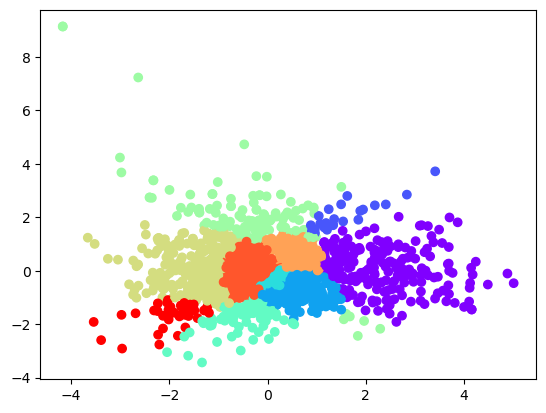

In [17]:
plt.scatter(pca_df[0], pca_df[1], c=pca_df['predicted_clusters'], cmap='rainbow')